Reviewed: Jan 2024

This notebook may be run in Colab

To run this code on the GPU:

**Runtime -> Change runtime type -> GPU**

# Building a NN using PyTorch

Given an image of a clothing item, we will predict the item.
We will show how to add layers to a NN using [nn.Torch](https://pytorch.org/docs/stable/nn.html), and [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) which
is an ordered container of modules. The data is passed through all the modules in the same order as defined.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F  # For F.relu
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.optim as optim   # SGD
import time

In [2]:
#Check if GPU is available. The program will run using the GPU if available,
#otherwise will use CPU.
cuda = torch.cuda.is_available()
cuda #returns a Boolean indicating availability of GPU

False

In [3]:
NN = nn.Sequential(nn.Linear(10,4),
                   nn.ReLU(),
                   nn.Linear(4,1),
                   nn.ReLU())



## The Fashion MNIST data

We will use 4096 training images, and 1024 validation images. (Normally, when we train neural networks, we will try to use all the data that we have. The only reason I'm limiting our training and validation set is so that the code runs quickly for demonstration purposes.)

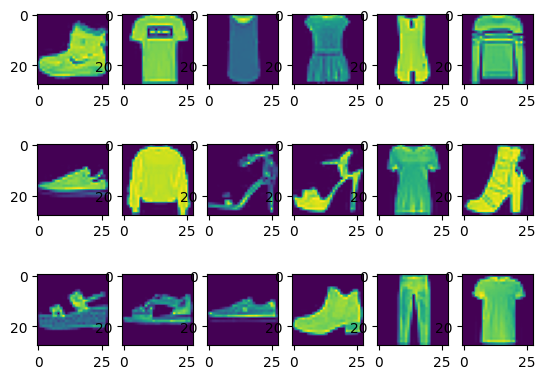

In [4]:
mnist_images = datasets.FashionMNIST('data', train=True, download=True)

for k, (image, label) in enumerate(mnist_images):
    if k >= 18:
        break
    plt.subplot(3, 6, k+1)
    plt.imshow(image)

In [5]:
mnist_data = datasets.FashionMNIST('data', train=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)

print(len(mnist_data))

mnist_train = mnist_data[:50000]
mnist_val   = mnist_data[50000:]

60000


In [6]:
# no. obs in train and validation sets
len(mnist_train), len(mnist_val)

(50000, 10000)

## The model

[nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) is the base class for **all** NN modules. It contains the methods for NN training.

[nn.Sequential]((https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) is a subclass of NN.Module.
It allows for chaining of the layers and is a quick way to build a NN when this is allowed.

Depending on the architecture of the NN, we may use nn.Module, or nn.Sequential, or both to build our model.

Here, we will fit a softmax regression, which chaining together a vectorised layer and a linear layer. (There is a softmax operation which we will discuss shortly).

Each image is 28 x 28.

Define the model - call it `model`- so that and input image is:

**flattened (vectorised) --> linear layer that has 10 outputs -->Classify with softmax.**

PyTorch does not implicitly reshape the inputs. Thus define the flatten
layer [`nn.Flatten()`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) to reshape the inputs (to a vector) before the linear layer in the network.

In [7]:
#Can define MLP using nn.Sequential or nn.Module

# Defining MLP using sequential
model = nn.Sequential(nn.Flatten(),
                    nn.Linear(28*28, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

In [8]:
# Defining MLP using nn.Module
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        #self.flat = nn.Flatten()
        self.fc1 = nn.Linear(28*28,256)
        #self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256,10)

    def forward(self,x):
        #x = x.view(28*28,-1)   # This gets an error dimensions matrix multiplication not compatible
        x = x.view(-1,28*28)  #Flatten input --> column vector
        x = self.fc1(x)
        x = F.relu(x)
        # x = F.relu(self.fc1(x))
        #x = self.relu1(x)
        x = self.fc2(x)
        return x

# Construct an instance of the MLP() class, which is our model
# If you don't run the line below, there is no model.
model = MLP()

## **Test the model**

Test the model gives expected output by feeding in one image.

In [9]:
first_img, first_label = mnist_train[0]
output = model(first_img)
print(first_img.shape)
print(output)
print(output.shape)

torch.Size([1, 28, 28])
tensor([[-0.1601, -0.1363,  0.2208,  0.0183, -0.0941,  0.1264, -0.0366, -0.1869,
         -0.0738,  0.0472]], grad_fn=<AddmmBackward0>)
torch.Size([1, 10])


In [10]:
# Can feed in simulated input
input = torch.randn((1,28,28))
output = model(input)
print(output.shape)


torch.Size([1, 10])


The tensor output shows the activation of the 10 output neurons in our neural network. We still need to go from this output to either a (discrete) prediction, or a (continuous) distribution showing a computed probability of the image belonging to each class (each digit).

The output of the linear layer, the logits, is passed through a softmax function to obtain probabilities - this is handled by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) so we do not add it into our chain.


In [11]:
def init_weights(m):
    """
    Custom parameter initialisation

    parameter:

          m: layers of the model
    """
    if type(m) == nn.Linear:
        nn.init.normal_(tensor=m.weight, mean=0.0,std=0.01)


model.apply(init_weights)

MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [12]:
# For this class, it's optional to use the GPU

#Set up device to do computation. Device is either cpu or gpu.
#Set device = gpu if gpu available
device = torch.device("cuda" if cuda else "cpu")

#Transfer model to device. (Also have to transfer data to device, which will do later)
model.to(device)
print(model)

MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


## Training

In [13]:
num_workers = 3 if cuda else 0

def train(model, data, batch_size=64, num_epochs=1, learning_rate=0.05, num_workers=num_workers):

    """
    For num_epoch of times, iterate over the mini-batches and
    and update the parameters at each iteration.
    Record the training loss, and validation error, and plot each over iterations.
    At the start of each epoch the data is shuffled and a new set of
    mini-batches is created.

    Parameters:

        model: the neural net
        batch_size (int): mini-batch size of training and validation sets
        num_epochs(int): number of epochs to train

    Returns:

        None
    """

    train_loader = DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    #Pick loss and optimiser to use in training
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate) # In Week 5 we will see variants of SGD that perform better than SGD

    #Store evaluation metrics
    iters, losses, train_acc, val_acc = [], [], [], []

    # Training loop
    n = 0 # the number of iterations
    start_time = time.time()

    for epoch in range(num_epochs):
        # Iterate over the mini-batches
        for imgs, labels in iter(train_loader):

            # Transfer data to device
            imgs = imgs.to(device)
            labels = labels.to(device)

            # Forward pass: outputs logits for each image and computes the loss value
            out = model(imgs)
            loss = criterion(out, labels)

            # Backward pass and update
            loss.backward()               # Backprop
            optimizer.step()              # Update each parameter
            optimizer.zero_grad()         # reset gradients

        # Save the current training information to report
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train=True)) # compute training accuracy
        val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
        n += 1

        #End of an epoch
        end_time = time.time()
        # running_loss /= len(train_loader)
        print(f'Training Loss in epoch {epoch+1}/{num_epochs}: {round(losses[-1],5)}, Time: {round(end_time - start_time,5)}s')

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

`get_accuracy` helper function. To turn the probabilities into a discrete prediction, we will take the digit with the highest probability. Because of the way softmax is computed, the digit with the highest probability is the same as the digit with the (pre-activation) output value.

In [14]:
def get_accuracy(model, train=False):
    if train:
        data = mnist_train
    else:
        data = mnist_val

    correct = 0
    # i = 0
    total = 0
    for imgs, labels in DataLoader(data, batch_size=64):
        # print(i)
        # i += 1
        # Transfer data to device
        imgs = imgs.to(device)
        labels = labels.to(device)

        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

## Debugging

One technique that researchers often use to debug their network is to first make sure that their network can overfit to a small dataset. This sanity check ensures that you are using the right variable names, and rules out other programming bugs that are difficult to discern from architecture issues.

Common programming issues that can arise include:

Forgetting to call optimizer.zero_grad() when using PyTorch. In general, this line of code is included at the beginning of the code for a training iteration, as opposed to at the end.
Using the wrong criterion, or using a loss function with incorrectly formated variables.
Adding a non-linearity after the final layer. In general we don't add a non-linearity in the forward function of the network, so that the computation of the loss function and the associated optimization steps are more numerically stable.
Forgetting non-linearity layers in the forward function.

Training Loss in epoch 1/5: 0.00225, Time: 0.33155s
Training Loss in epoch 2/5: 0.00225, Time: 0.48265s
Training Loss in epoch 3/5: 0.00224, Time: 0.64654s
Training Loss in epoch 4/5: 0.00224, Time: 0.7936s
Training Loss in epoch 5/5: 0.00224, Time: 0.9503s


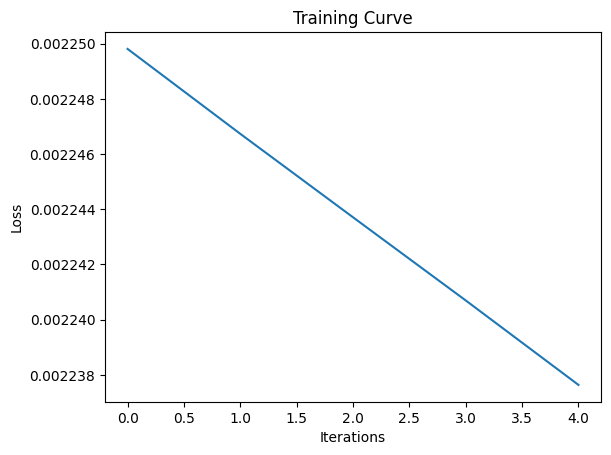

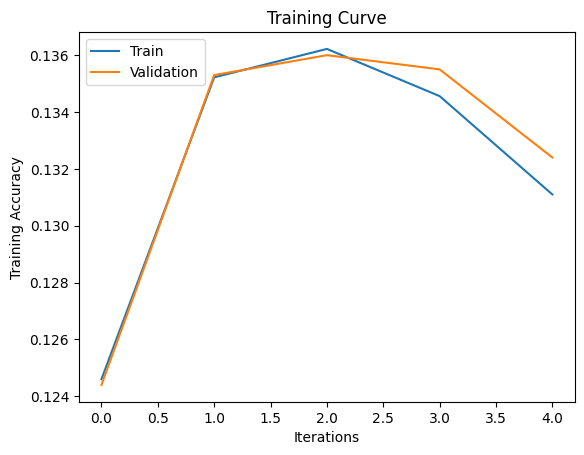

Final Training Accuracy: 0.1311
Final Validation Accuracy: 0.1324


In [ ]:
debug_data = mnist_train[:512] #sample size = batch size
train(model, debug_data, batch_size=512, num_epochs=5)

Only when we have ensured that our model can overfit to a small dataset do we begin training the neural network our full training set.

Training Loss in epoch 1/50: 0.00015, Time: 3.4405s
Training Loss in epoch 2/50: 0.00014, Time: 6.26233s
Training Loss in epoch 3/50: 0.00015, Time: 9.46657s
Training Loss in epoch 4/50: 0.00016, Time: 12.77064s
Training Loss in epoch 5/50: 0.00015, Time: 16.05001s
Training Loss in epoch 6/50: 0.00014, Time: 19.3873s
Training Loss in epoch 7/50: 0.00014, Time: 22.83224s
Training Loss in epoch 8/50: 0.00015, Time: 26.19697s
Training Loss in epoch 9/50: 0.00014, Time: 29.71522s
Training Loss in epoch 10/50: 0.00014, Time: 33.15324s
Training Loss in epoch 11/50: 0.00015, Time: 36.69613s
Training Loss in epoch 12/50: 0.00014, Time: 39.80743s
Training Loss in epoch 13/50: 0.00013, Time: 43.74437s
Training Loss in epoch 14/50: 0.00013, Time: 46.79037s
Training Loss in epoch 15/50: 0.00014, Time: 50.04131s
Training Loss in epoch 16/50: 0.00012, Time: 52.99109s
Training Loss in epoch 17/50: 0.00013, Time: 56.32009s
Training Loss in epoch 18/50: 0.00014, Time: 59.11831s
Training Loss in epoch 1

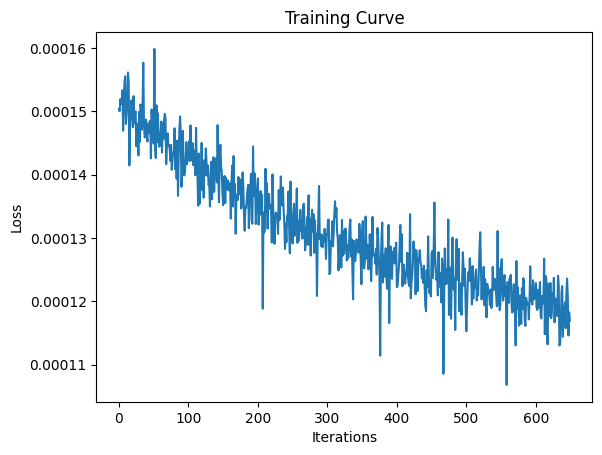

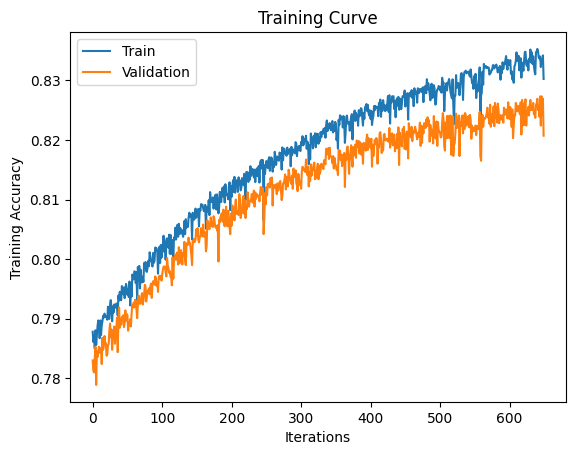

Final Training Accuracy: 0.83022
Final Validation Accuracy: 0.8207


In [72]:
train(model, mnist_train, batch_size=4096, num_epochs=50)

# Uncomment to save the model into your working directory
#torch.save(model.state_dict(), "FashionMnist_model")

## Going further

At this point, we can begin tuning hyperparameters, and tweak the architecture of our network to improve our validation accuracy. We can also check for any underfitting or overfitting. We will see how to do this in the next few lectures and classes.